# Mushroom Invariance Test

- **Dataset**: Mushrooms (LIBSVM)
- **Model**: 3-layer MLP (100 hidden neurons, ReLU)
- **Variable**: Scaling coefficient $k \in \{0, 5, 10, 15, 20\}$. Features are multiplied by $e^a, a \sim U[-k, k]$.
- **Goal**: 
  - **MuAdam-SANIA** should be scaling-invariant (horizontal line).
  - **AdamW** and **Muon** should show monotonic performance drop.
- **Technical**: Uses `float64` to avoid numerical errors dominating at $k=20$.


In [1]:
# !pip install optuna evaluate loguru

In [1]:
import os
import re
import json
import subprocess
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

REPO_ROOT = Path.cwd()
SRC = REPO_ROOT / "src" / "run_experiment.py"
RESULTS_DIR = REPO_ROOT / "src" / "libsvm" / "results_stress_test"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

assert SRC.exists(), "Please run this notebook from the repository root."
print("Repo root:", REPO_ROOT)
print("Results dir:", RESULTS_DIR)


Repo root: /root/work/LIB
Results dir: /root/work/LIB/src/libsvm/results_stress_test


## 1. Helper Functions
Copying helper functions from the benchmark notebook to parse results reliable.

In [2]:
def run_cmd(cmd, cwd=REPO_ROOT):
    print("\n$ " + " ".join(map(str, cmd)))
    p = subprocess.run(
        cmd, cwd=str(cwd), text=True,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    # print(p.stdout) # Uncomment to debug output
    if p.returncode != 0:
        print(p.stdout)
        raise RuntimeError(f"Command failed with exit code {p.returncode}")
    return p.stdout

_metric_re = re.compile(r"^(?P<name>[A-Za-z0-9_]+):\s*(?P<mean>[-+eE0-9.]+)\+\-(?P<std>[-+eE0-9.]+)\s*$")

def parse_results_txt(path: Path):
    out = {}
    if not path.exists():
        return out
    for line in path.read_text().splitlines():
        m = _metric_re.match(line.strip())
        if m:
            out[m.group("name") + "_mean"] = float(m.group("mean"))
            out[m.group("name") + "_std"] = float(m.group("std"))
    return out

def snapshot_mtimes(results_dir: Path):
    return {p: p.stat().st_mtime for p in results_dir.glob("*.txt")}

def find_new_or_modified(before_mtimes, results_dir: Path):
    out = []
    for p in results_dir.glob("*.txt"):
        m = p.stat().st_mtime
        if p not in before_mtimes or m > before_mtimes[p]:
            out.append(p)
    return sorted(out, key=lambda p: p.stat().st_mtime)


## 2. Experiment Setup
Defining the parameters for the stress test.

In [3]:
SCALES = [0, 5, 10]

OPTIMIZERS = [
    {
        "name": "AdamW",
        "args": ["--optimizer", "adamw"]
    },
    {
        "name": "Muon",
        "args": ["--optimizer", "muon", "--momentum", "0.9", "--ns_steps", "20", "--lr", "0.02"]
    },
    {
        "name": "MuAdam-SANIA",
        "args": ["--optimizer", "taia", "--lmo", "spectral", "--precondition_type", "adam_sania", "--ns_steps", "20", "--momentum", "0.9", "--lr", "0.0001"]
    }
]

COMMON_ARGS = [
    "--dataset", "mushrooms",
    "--model", "mlp",
    "--hidden_dim", "100",
    "--n_epoches_train", "100",
    "--batch_size", "128",
    "--no_bias",
    "--weight_init", "uniform",
    "--dtype", "float64",
    "--results_path", "results_stress_test",
    "--eval_runs", "2",
    "--verbose"
]

## 3. Run Experiments
Running the loop over scaling factors $k$ and optimizers.

In [4]:
results = []

for k in SCALES:
    print(f"\n{'='*20} Scaling K={k} {'='*20}")
    for opt in OPTIMIZERS:
        run_name = f"stress_k{k}_{opt['name']}"
        print(f"... Running {opt['name']} with k={k} ...")
        
        # Construct command
        cmd = ["python", str(SRC)] + COMMON_ARGS + opt["args"]
        cmd += ["--run_prefix", run_name]
        
        cmd += ["--scale", "--scale_bound", str(k)]
        
        # Capture new results file
        before = snapshot_mtimes(RESULTS_DIR)
        run_cmd(cmd)
        changed = find_new_or_modified(before, RESULTS_DIR)
        
        if not changed:
             print(f"WARNING: No results found for {run_name}")
             continue
             
        res_file = changed[-1]
        metrics = parse_results_txt(res_file)
        
        # Log data
        row = {
            "optimizer": opt["name"],
            "k": k,
            "test_accuracy": metrics.get("test_accuracy_mean", None),
            "test_loss": metrics.get("test_loss_mean", None),
            "file": str(res_file)
        }
        print(f" -> Result: Acc={row['test_accuracy']}")
        results.append(row)

df_res = pd.DataFrame(results)
df_res.to_csv("stress_test_summary.csv", index=False)
print("Done.")
df_res



==================== Scaling K=0 ====================
... Running AdamW with k=0 ...

$ python /root/work/LIB/src/run_experiment.py --dataset mushrooms --model mlp --hidden_dim 100 --n_epoches_train 100 --batch_size 128 --no_bias --weight_init uniform --dtype float64 --results_path results_stress_test --eval_runs 2 --verbose --optimizer adamw --run_prefix stress_k0_AdamW --scale --scale_bound 0
 -> Result: Acc=0.9981527093596059
... Running Muon with k=0 ...

$ python /root/work/LIB/src/run_experiment.py --dataset mushrooms --model mlp --hidden_dim 100 --n_epoches_train 100 --batch_size 128 --no_bias --weight_init uniform --dtype float64 --results_path results_stress_test --eval_runs 2 --verbose --optimizer muon --momentum 0.9 --ns_steps 20 --lr 0.02 --run_prefix stress_k0_Muon --scale --scale_bound 0
 -> Result: Acc=1.0
... Running MuAdam-SANIA with k=0 ...

$ python /root/work/LIB/src/run_experiment.py --dataset mushrooms --model mlp --hidden_dim 100 --n_epoches_train 100 --batch_si

,optimizer,k,test_accuracy,test_loss,file
0,AdamW,0,0.998153,0.012541,/root/work/LIB/src/libsvm/results_stress_test/...
1,Muon,0,1.000000,0.000194,/root/work/LIB/src/libsvm/results_stress_test/...
2,MuAdam-SANIA,0,0.999384,0.249685,/root/work/LIB/src/libsvm/results_stress_test/...
3,AdamW,5,0.999384,0.025164,/root/work/LIB/src/libsvm/results_stress_test/...
4,Muon,5,1.000000,0.000124,/root/work/LIB/src/libsvm/results_stress_test/...
5,MuAdam-SANIA,5,1.000000,0.013618,/root/work/LIB/src/libsvm/results_stress_test/...
6,AdamW,10,0.998153,0.015965,/root/work/LIB/src/libsvm/results_stress_test/...
7,Muon,10,0.932882,1.264895,/root/work/LIB/src/libsvm/results_stress_test/...
8,MuAdam-SANIA,10,0.987685,0.161647,/root/work/LIB/src/libsvm/results_stress_test/...


## 4. Visualization
Plotting Final Test Accuracy / Loss vs K.

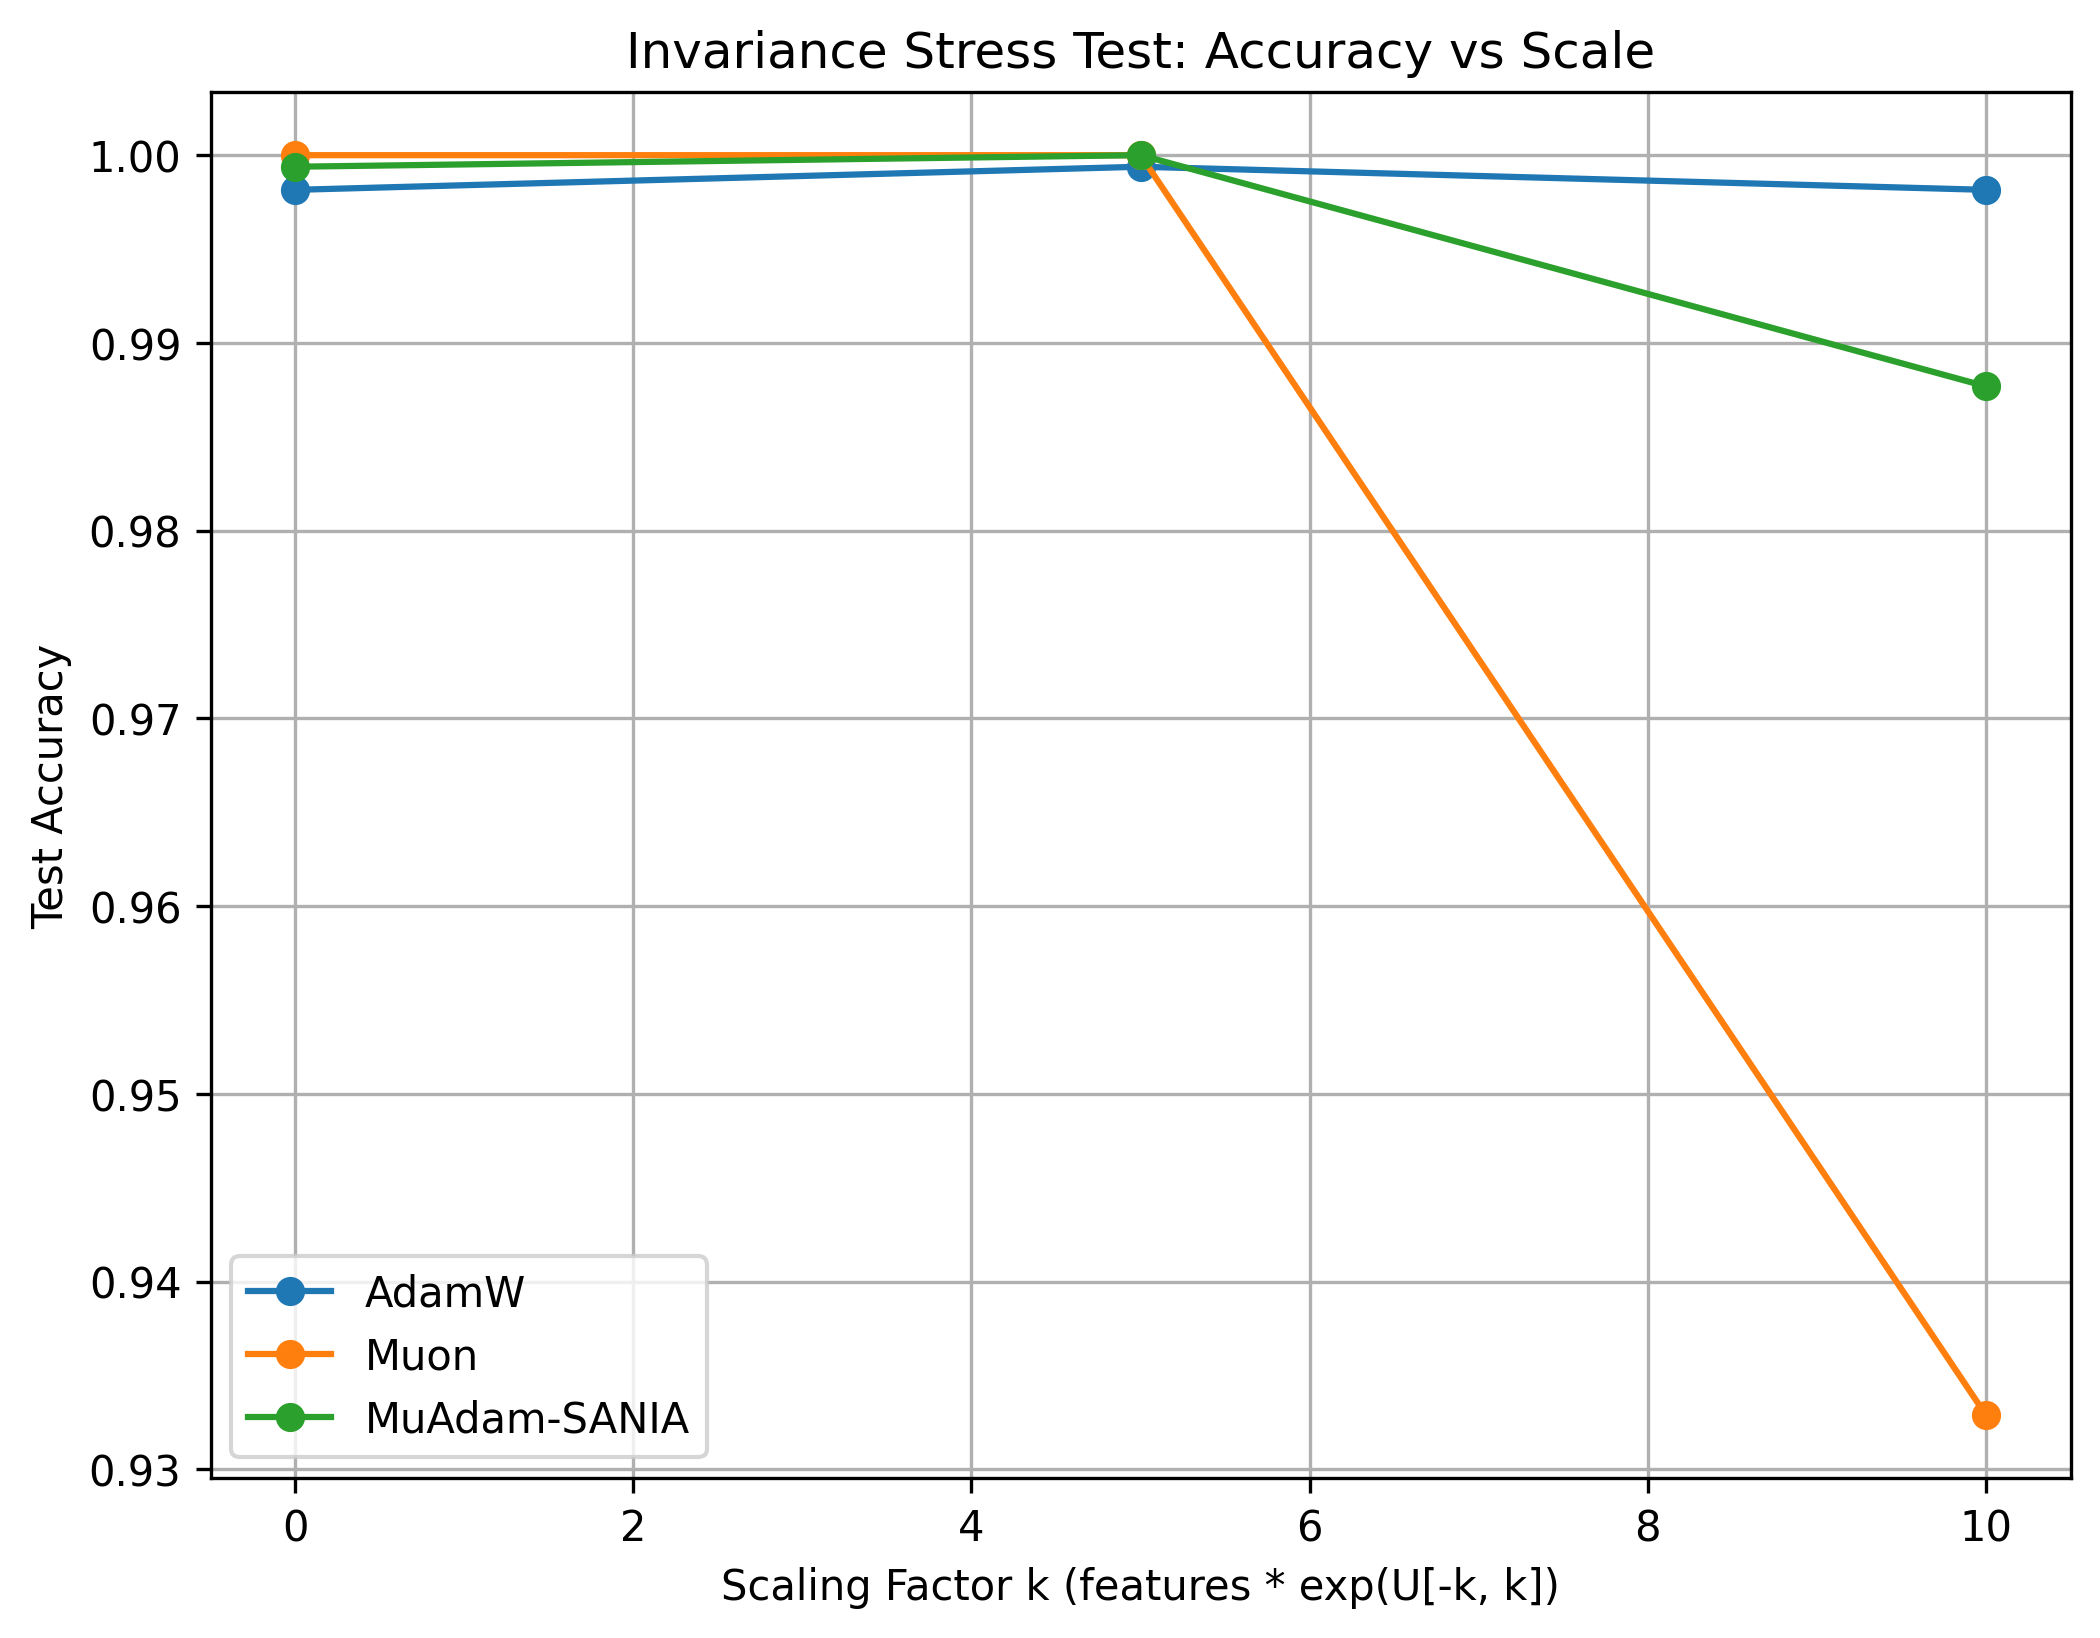

In [5]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for opt_name in df_res["optimizer"].unique():
    subset = df_res[df_res["optimizer"] == opt_name].sort_values("k")
    ax.plot(subset["k"], subset["test_accuracy"], marker='o', label=opt_name)

ax.set_xlabel("Scaling Factor k (features * exp(U[-k, k])")
ax.set_ylabel("Test Accuracy")
ax.set_title("Invariance Stress Test: Accuracy vs Scale")
ax.legend()
ax.grid(True)
plt.show()


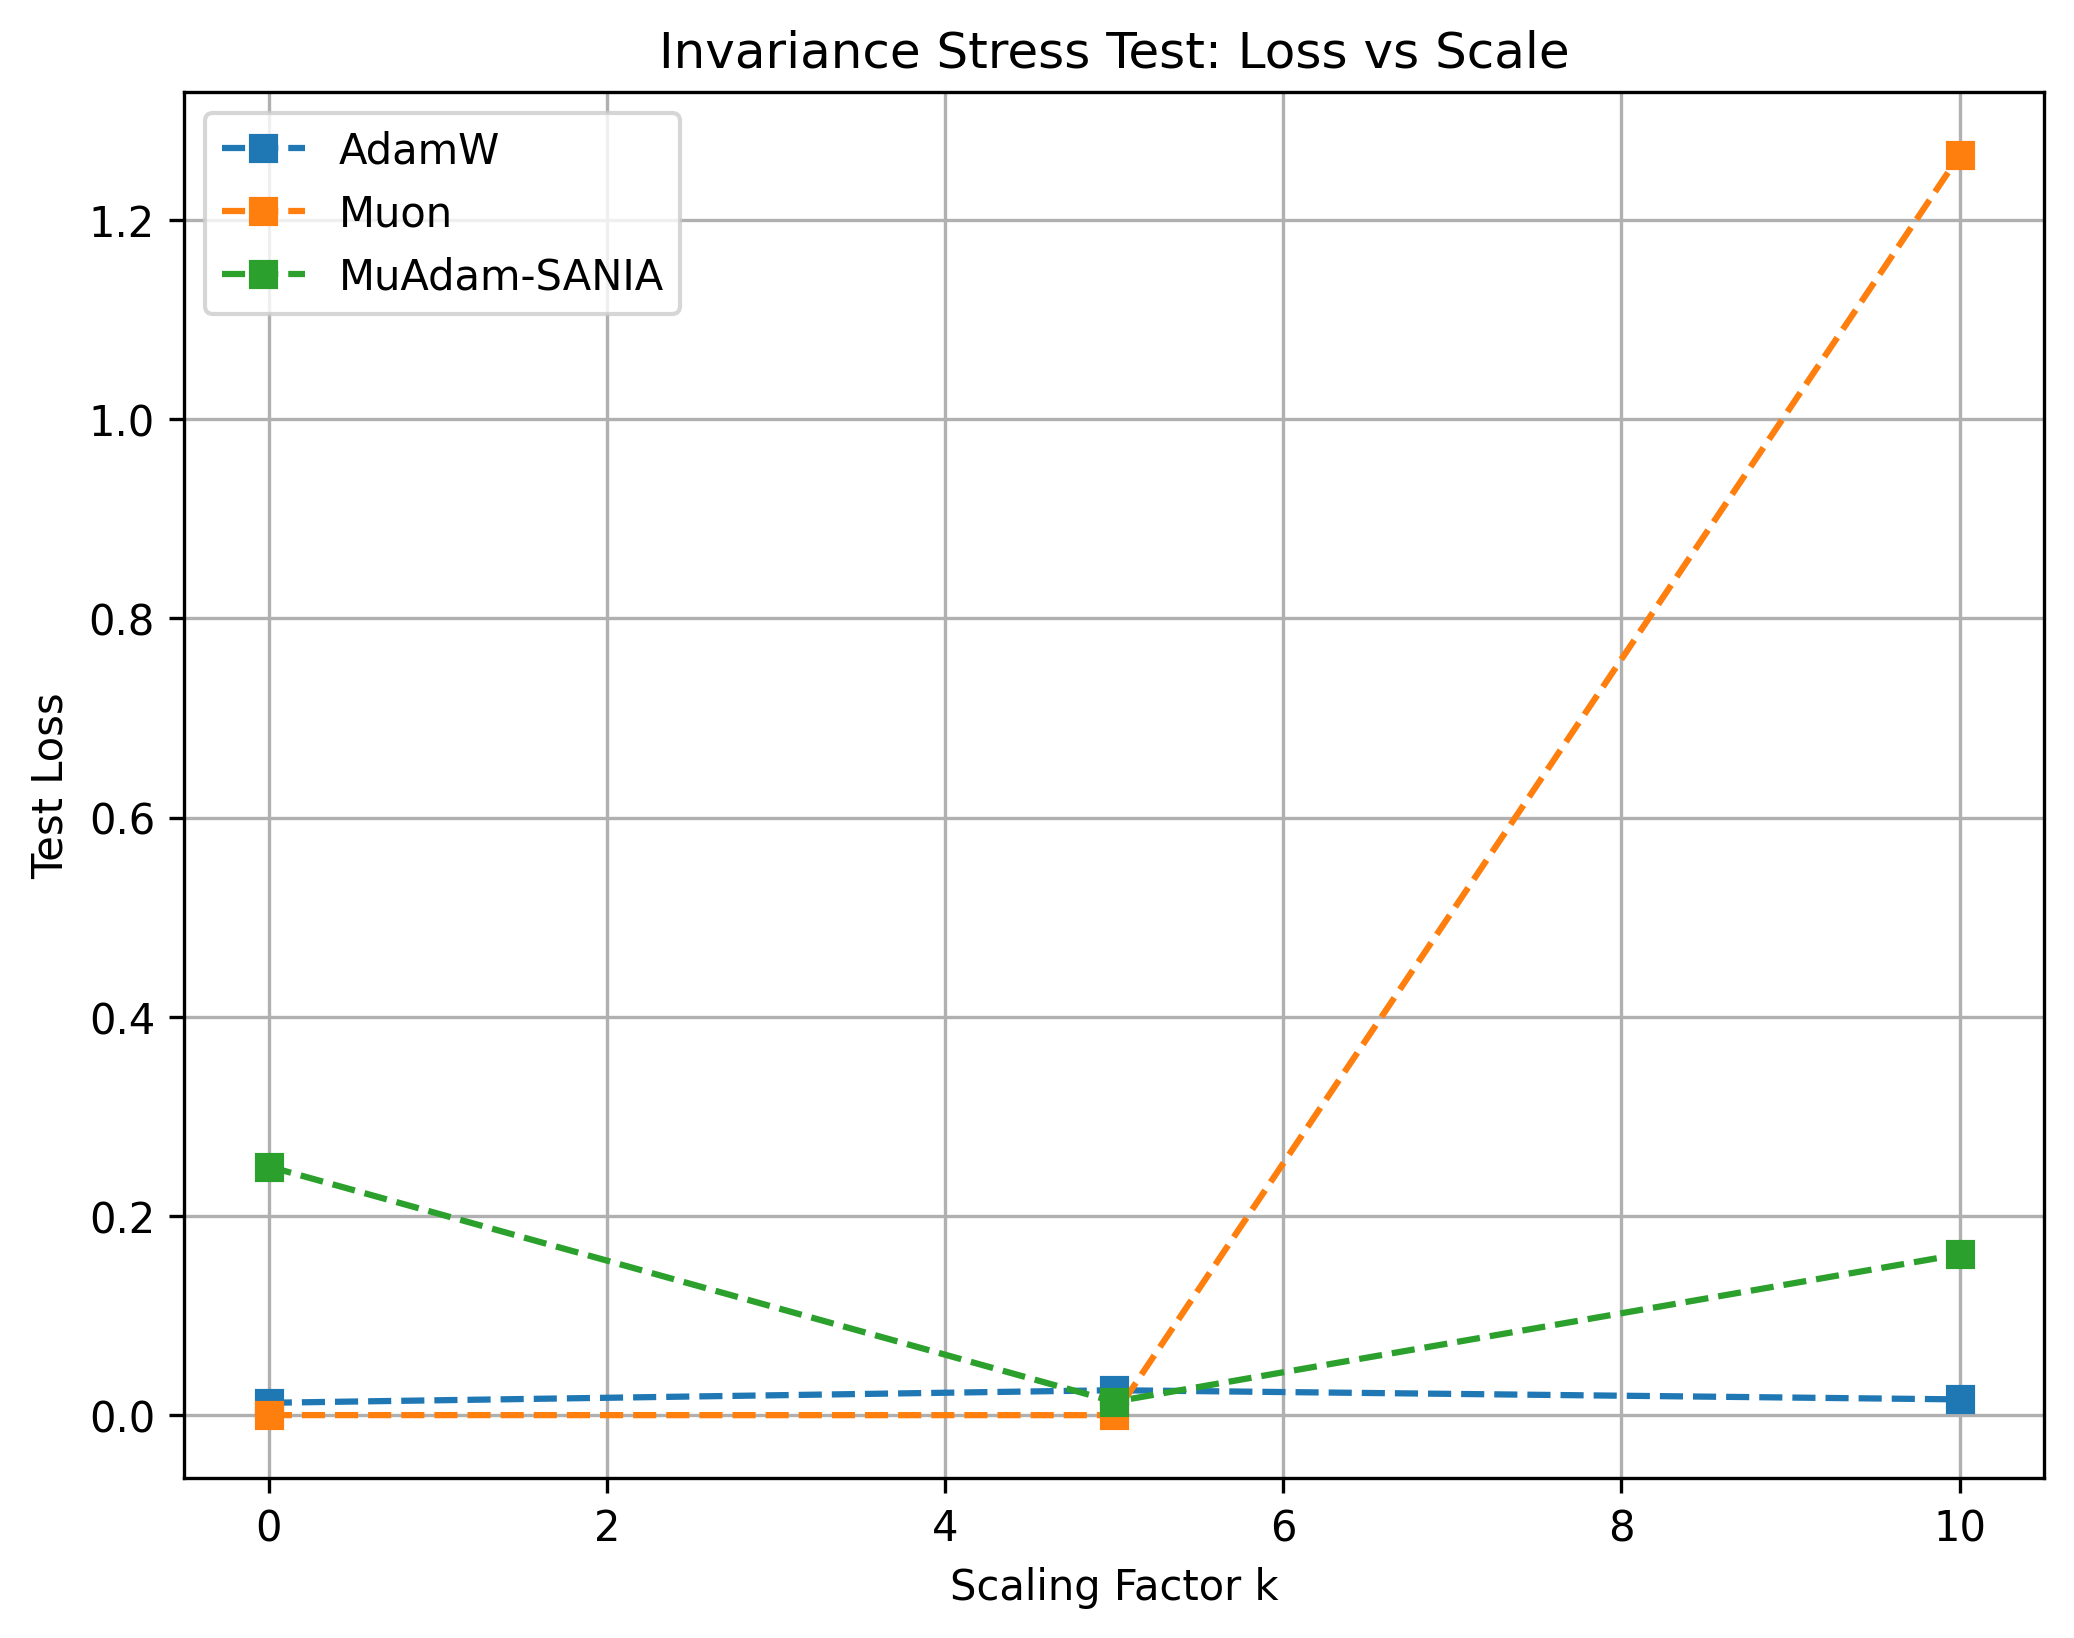

In [6]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for opt_name in df_res["optimizer"].unique():
    subset = df_res[df_res["optimizer"] == opt_name].sort_values("k")
    ax.plot(subset["k"], subset["test_loss"], marker='s', linestyle='--', label=opt_name)

ax.set_xlabel("Scaling Factor k")
ax.set_ylabel("Test Loss")
ax.set_title("Invariance Stress Test: Loss vs Scale")
ax.legend()
ax.grid(True)
plt.show()
